In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import pymc
from pymc import utils
from pymc.database import base
import pygem_input as input

import glob

#plotting functions
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.mlab as mlab
from scipy.stats import gaussian_kde
import scipy.stats as stats
from scipy.stats import truncnorm
from scipy.stats import norm

variables = ['massbal', 'precfactor', 'tempchange', 'ddfsnow']  
vn_title_dict = {'massbal':'Mass Balance',                                                                      
                 'precfactor':'Precipitation Factor',                                                              
                 'tempchange':'Temperature Bias',                                                               
                 'ddfsnow':'DDF Snow'}
vn_label_dict = {'massbal':'Mass balance\n[mwea]',                                                                      
                 'precfactor':'Precipitation factor\n[-]',                                                              
                 'tempchange':'Temperature bias\n[degC]',                                                               
                 'ddfsnow':'DDF Snow\n[mwe $degC^{-1} d^{-1}$]'}
metric_title_dict = {'Gelman-Rubin':'Gelman-Rubin Statistic',
                     'MC Error': 'Monte Carlo Error',
                     'Effective N': 'Effective Sample Size'}
metrics = ['Gelman-Rubin', 'MC Error', 'Effective N']

suffix = '_trunc'
mcmc_data_fp = input.main_directory + '/../MCMC_data/'                                                                  
mcmc_prior_fp = mcmc_data_fp + 'prior_comparison/' 
mcmc_output_netcdf_fp = '../MCMC_data/netcdf' + suffix + '/'
mcmc_output_figures_fp = '../MCMC_data/figures' + suffix + '/'
mcmc_output_tables_fp = '../MCMC_data/tables/'
mcmc_output_csv_fp = '../MCMC_data/csv' + suffix + '/'
mcmc_output_hist_fp = '../MCMC_data/hist' + suffix + '/'

In [6]:
def plot_priors(filepath='../MCMC_data/prior_comparison/', region='all', iters=30000, burn=0):
    '''
    Plots scatter plots of posterior distribution statistics for
    independent variables.
    '''
    priors = ['trunc', 'uniform']
    metrics = ['mean', 'stdev']
    variables = ['massbal', 'precfactor', 'tempchange', 'ddfsnow']
    vn_title_dict = {'massbal':'Mass Balance',
                     'precfactor':'Precipitation Factor',
                     'tempchange':'Temperature Bias',
                     'ddfsnow':'DDF Snow'}
    vn_label_dict = {'massbal':'Mass balance\n[mwea]',
                     'precfactor':'Precipitation factor\n[-]',
                     'tempchange':'Temperature bias\n[$^{o}$C]',
                     'ddfsnow':'DDFsnow\n[mm we $^{o}$C$^{-1}$ d$^{-1}$]'}
    prior_title_dict = {'trunc':'Truncated Normal Distribution',
                        'uniform': 'Uniform Distribution'}
    metric_title_dict = {'stdev': 'Standard Deviation',
                         'mean': 'Mean'}

    prior_dict = {}

    for prior in priors:
        if region in [13, 14, 15]:
            df = pd.read_csv(filepath + 'prior' + prior + '_' + 'region' +
                             str(region) + '_' + str(iters) + 'iterations_' +
                             str(burn) + 'burn.csv')
            prior_dict[prior] = df
        elif region=='all':
            regions = [13, 14, 15]
            dfs = []
            for reg in regions:
                dfs.append(pd.read_csv(filepath + 'prior' + prior + '_' + 'region' +
                             str(reg) + '_' + str(iters) + 'iterations_' +
                             str(burn) + 'burn.csv'))
            prior_dict[prior] = pd.concat(dfs)


    # hard code font sizes
    ticks=10
    suptitle=14
    supy = 0.95
    title=12
    suby = 1.05
    label=10
    plotline=0.5
    legend=10
    figsize=(6.5, 9)
    dpi=100
    hspace=0.4
    wspace=0.3
    labelpad1=5
    labelpad2=5
    
    v_len = len(variables)
    p_len = len(priors)
    m_len = len(metrics)

    ticks = {}
    ticks['massbal_stdev'] = np.arange(0.1, 0.51, 0.1)
    ticks['massbal_mean'] = np.arange(-2, 2.1, 2)
    ticks['precfactor_stdev'] = np.arange(0.4, 1.1, 0.2)
    ticks['precfactor_mean'] = np.arange(0.5, 2.01, 0.5)
    ticks['tempchange_stdev'] = np.arange(1.0, 6.1, 1)
    ticks['tempchange_mean'] = np.arange(-5, 6, 5)
    ticks['ddfsnow_stdev'] = np.arange(0.0012, 0.002, 0.0003)
    ticks['ddfsnow_mean'] = np.arange(0.003, 0.0046, 0.0005)

    lims = {}
    lims['massbal_stdev'] = [0.1, 0.4]
    lims['massbal_mean'] = [-3, 3]
    lims['precfactor_stdev'] = [0.3, 0.9]
    lims['precfactor_mean'] = [0.5, 2]
    lims['tempchange_stdev'] = [0.8, 6]
    lims['tempchange_mean'] = [-9,7]
    lims['ddfsnow_stdev'] = [0.00105, 0.00185]
    lims['ddfsnow_mean'] = [0.003, 0.0045]

    # create figure
    fig = plt.figure(figsize=figsize, dpi=dpi)
    plt.subplots_adjust(wspace=wspace, hspace=hspace)

    # write title
    #plt.suptitle('Prior Probability Comparison ' +
                 #str(iters) + ' iterations ' + str(burn) + ' burn-in',
                 #fontsize=suptitle, y=supy)

    # create subplot for each variable
    for v, vn in enumerate(variables):

        # create subplot for each variable
        for m, metric in enumerate(metrics):

            # plot histogram
            ax = plt.subplot(v_len, m_len, m_len*v+m+1)
            x = prior_dict['trunc'][vn + '_' + metric][::1]
            y = prior_dict['uniform'][vn + '_' + metric][::1]
            if metric == 'mean' and vn == 'massbal':
                plt.scatter(x=x, y=y, marker='o', facecolors='none', edgecolors = 'black', s=0.2)
            else:
                plt.scatter(x=x, y=y, marker='o', facecolors='none', edgecolors = 'black', s=0.01)                
            plt.plot([-10, 10], [-10, 10], color='black', linewidth=plotline)

            ylabel = 'Uniform'
            xlabel = 'Truncated Normal'

            if v == 0:
                plt.title(metric_title_dict[metric], fontsize=label, y=suby)
            if m == 0:
                ax.set_ylabel(vn_label_dict[vn] + '\n\n' + ylabel,
                              fontsize=label, labelpad=labelpad1)
            #else:
            #    ax.set_ylabel(ylabel,
            #                  fontsize=label, labelpad=labelpad2)

            ax.set_xticks(ticks[vn + '_' + metric])
            ax.set_yticks(ticks[vn + '_' + metric])
            ax.set_ylim(lims[vn + '_' + metric])
            ax.set_xlim(lims[vn + '_' + metric])

            if vn=='ddfsnow':
                a = ax.get_xticks()
                b = a.copy()
                b *= 1000
                ax.set_xticks(a)
                ax.set_xticklabels(b)
                c = ax.get_yticks()
                d = c.copy()
                d *= 1000
                ax.set_yticks(c)
                ax.set_yticklabels(d)
            
            if v == 3:
                ax.set_xlabel(xlabel, fontsize=label, labelpad=labelpad2)

    #plt.savefig(mcmc_prior_fp + 'prior_sensitivity.jpg',
      #          bbox_inches='tight')

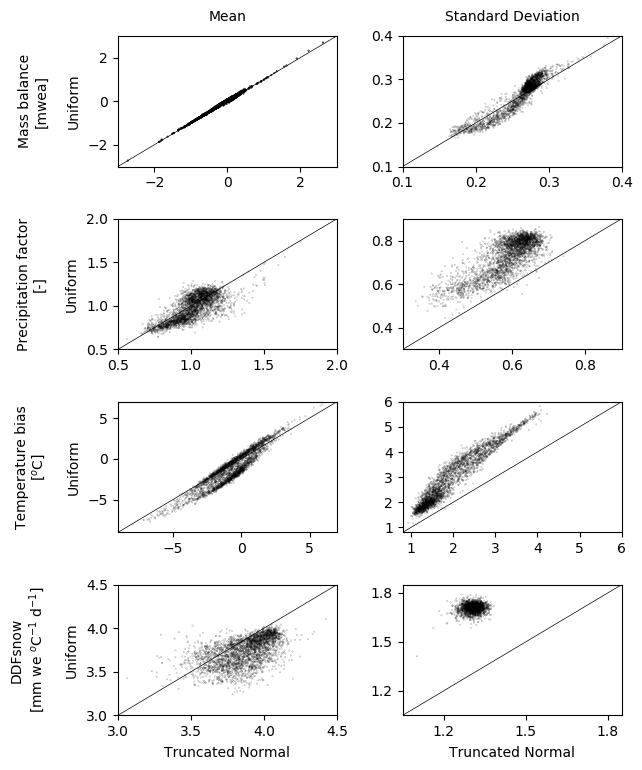

In [7]:
plot_priors()